# RL coursework, part I (20 pts total)
---

**Name:** Alina Marchenko

**SN:** 23226377

---

**Due date:** *April 11th, 2024*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

C:\Users\alina\AppData\Local\Temp\ipykernel_9904\1175342693.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f

    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif

      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])

      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)

      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

squremax policy is undefined for 0? how to deal with it
when this happens, if you do want to define it, do it and make a note of it
all initial values should be set to 0
add a small epsilon in canculation of the policies 
after squaring add a small constant 

something about t parameter when 
frequences, episodes(can be chuned up, going ) for any cont task we can cuck it up, consider a sequence up to some value
step into the shoes of the learning algo, think what it can see
picking these parameter is trial and error process
pick t that such that 1/1-labda, doing 10 steps before bootstrapping, labda 0.99 - 100 steps
ppo, critic algo, don't set lambda or set it to 1, n step return ,parameter may have more than one role
lambda 0.9 is a good number for unknown reason, reference in papers 

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.

    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.

    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

Important points: takes into account uncertainty and actual values
$$ q(a) \leq Q(a) + U(a) $$



action maximizing UCB, selecting actions greedily wrt Q + U
$$
a_t = \underset{a \in \mathcal{A}}{\mathrm{argmax}} \, (Q_t(a) + U_t(a))
$$
$$\begin{equation*}
A_t = argmax_{a}\Bigl[Q_t(a) + c\sqrt{\frac{\log t}{N_t(a)}}\Bigr]
\end{equation*}
$$
if very uncertain about an action, pick it.
if we are certain, we only pick this action if the estimate itself is high
uncertaininty depends on # of times the action has been selected
small counts = large bound = big uncertainty - pick it to see how good it is
as cound goes up = small bound = estimated value is accurate

a is selected if 
---------value is high = Q_t is large
---------bound U is large(small count of picking a)


In [6]:
#step(self, previous_action, reward)
# Should update the statistics by updating the value for the previous_action towards the observed reward.
# (Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.
# (Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

# reset(self)
# Resets statistics (should be equivalent to constructing a new agent from scratch).
# Make sure that the initial values (after a reset) are all zero.
# **`__init__(self, name, number_of_arms, *args)`:**
# The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier, **kwargs):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.N_t = np.zeros(number_of_arms)
    self.t = 0
    self.Q_t = np.zeros(number_of_arms)
    self.reset()

  def step(self, previous_action, reward):
    if previous_action == None:
      action = np.random.randint(self._number_of_arms)
    else:
      self.t += 1
      self.N_t[previous_action] +=1
      self.Q_t[previous_action] += (reward - self.Q_t[previous_action])/ self.N_t[previous_action]
    
    
    U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))
    action_values = self.Q_t + U_t
    action = np.argmax(action_values)    
    
    return action

  def reset(self):
    self.N_t = np.zeros(self._number_of_arms)
    self.t = 0
    self.Q_t = np.zeros(self._number_of_arms)

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self.number_of_arms = number_of_arms
    self.epsilon = epsilon
    self.t = 0
    self.Q_t = np.zeros(number_of_arms)
    self.N_t = np.zeros(number_of_arms)
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    self.t += 1
    
    if previous_action is not None:
        self.N_t[previous_action] += 1
        self.Q_t[previous_action] +=(reward - self.Q_t[previous_action]) / self.N_t[previous_action]
    
    if callable(self.epsilon):
      #epsilon as a function of step
      epsilon = self.epsilon(self.t)
    else:
      epsilon = self.epsilon
    
    #choose next action, make sure we start with a random action to encourage exploration
    if np.random.rand() < epsilon or previous_action is None:
      #random
      action = np.random.randint(self.number_of_arms)
    else:
      #greedy
      max_q = np.max(self.Q_t)
      max_actions = np.where(self.Q_t == max_q)[0]
      #random break ties
      action = np.random.choice(max_actions) 
    
    return action

  def reset(self):
    self.N_t = np.zeros(self.number_of_arms, dtype=int)
    self.t = 0
    self.Q_t = np.zeros(self.number_of_arms)

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self.step_size = step_size
    self.baseline = baseline
    self.number_of_arms = number_of_arms
    self.t = 0
    #action preferences
    self.p = np.ones(self.number_of_arms)
    #self.p = np.ones(self.number_of_arms) / self.number_of_arms
    self.R_t = 0
    self.total_reward = 0
    #policy
    self.pi = self.p**2 / np.sum(self.p**2)
    self.reset()

  def step(self, previous_action, reward):
    if previous_action ==None:
      action = np.random.randint(self.number_of_arms)
    else:
      self.t +=1
      self.total_reward +=reward
      if self.baseline:
        self.R_t = (self.total_reward - reward) / (self.t - 1) if self.t > 1 else 0
      
      
      #p_b = np.arange(len(self.p))
      #p_b = np.delete(p_b, previous_action)
      
      
      #plugging pi(a) into p_t+1(a) we get p(a)+lambda*R_t(2/p(a)-2*p(a)/sum(p(b)^2)) for p(a)=p(b) 
      # and p(a)+lambda*R_t(0/p(a)-2*p(a)/sum(p(b)^2)) for p(a)!=p(b)
      grad = (0-(2*self.p))/np.sum(self.p**2)
      #add small constant so that we don't divide by 0
      grad[previous_action] += (2/(self.p[previous_action]+1e-10))
      self.p += self.step_size*(reward-self.R_t)*grad
      
      self.pi = self.p**2/np.sum(self.p**2)
        
      action = np.random.choice(self.number_of_arms, p = self.pi)
      
    return action

  def reset(self):
    self.total_reward = 0
    self.t = 0
    self.p = np.ones(self.number_of_arms)
    self.R_t = 0
    self.pi = self.p**2 / np.sum(self.p**2) 

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: divide by zero encountered in log
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))
C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: invalid value encountered in sqrt
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))


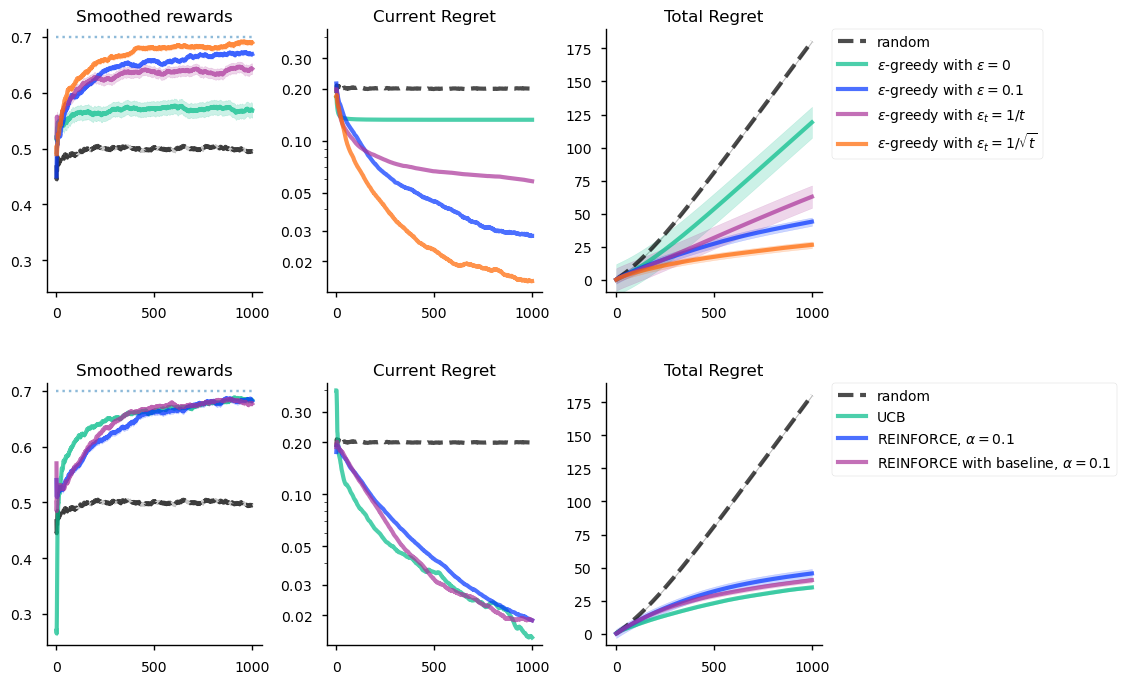

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.\

**Random**: this algorithm has the highest total regret over time as expected as it does not learn from previous actions and just picks a random action every time.
**Epsilon-greedy, epsilon 0**: When epsilon is 0 the statement: np.random.rand() < epsilon, will always be false, so the algorithm will never pick a random action and explore but instead always choose 'greedily'. This does better then random, however if we don't explore other options we don't update action values and hence there is more total regret than other epsilon values where random is combined with greedy. \
**Epsilon-greedy, epsilon 0.1**: This does very well and has the second lowest total regret, with a small epsilon there is a small chance of trying a new random action, hence exploring and updating action value function appropriately for when the algorithm does act greedily.\
**Epsilon-greedy, epsilon 1/t**: This epsilon is dynamic decreasing overtime(the larger t the smaller epsilon), with each time step we do more exploring and hence updating the action value function to more accurately represent the true values, as we do more exploring with time it makes sense to focus more on exploiting(choosing greedily).\
**Epsilon-greedy, epsilon 1/$\sqrt{t}$**: This algorithm is smaller then epsilon 1/t and we see that it balances exploration and exploitation even better than larger values. \
**UCB**: This algorithm performs the best and has the lowest total regret decreasing logarithmicly. UCB balances exploration and exploitation by choosing the action that has the best potential to give highest reward based on a combination of current rewards and uncertainty about the estimates.\
**Reinforce, alpha 0.1**: This is worst performing algorithm in terms of total regret compared to reinforce with baseline and UCB. This is expected as the variance in updates slows down convergence. \
**Reinforce with baseline, alpha 0.1**: This algorithm performs almost on par with UCB as baseline helps to reduce variance and hence improving learnng.

**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

**Epsilon-greedy, epsilon 0**: This is the worst performing algorithm that is just above random, but unlike random it always acts greedily and never explores other actions and accurately updates action value function.\
**Epsilon-greedy, epsilon 1/t**: This is second worse epsilon algorithm, it does some balancing on exploration vs exploitation, but the epsilon decreasing size over time is not small enough to do the balancing effectively, and it explores more then it exploits. \
**Epsilon-greedy, epsilon 0.1**:  Second best performing epsilom algorithm has a small enough epsilon to do some exploration and effectively use that exploration to act greedily for the rest of the time. However the static nature of this epsilon does not reduce exploration over time and hence performes worse then a smalled dynamic epsilon.\
**Epsilon-greedy, epsilon 1/$\sqrt{t}$**: This is the best choise of epsilon, it has the same tragectory as the static value at first however the dynamic decreasing epsilon motivates the exploitation at later steps when the action value functions converge to the true value. \

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: divide by zero encountered in log
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))
C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: invalid value encountered in sqrt
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))


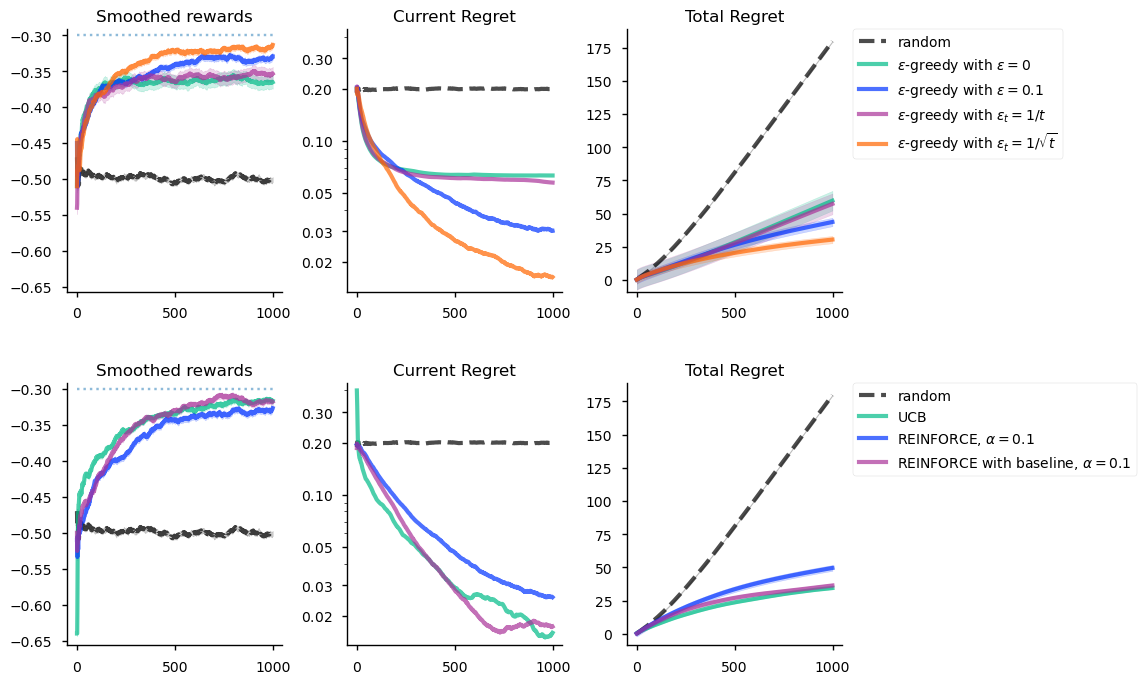

In [12]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

**Random**: this algorithm has the highest total regret and current regret over time just like in the first experiment. The rewards are now static at -0.5 as instead of reward of +1, and 0 in the previous experiemt now the reward is 0 for success and -1 for failure.
**Epsilon-greedy, epsilon 0**: This is now a lot closer in total and current regret and smoothed rewards to all other epsilon algorithms than in the case with positive rewards, although still does worst then the top 2 epsilons as described above. If the initial successful action is suboptimal, the algorithm is stuck with suboptimal performance.  \
**Epsilon-greedy, epsilon 0.1**: Similrarly to experiment 1 this is very close in performance to the best algorithm epsilon 1/$\sqrt{t}$ with a good balance of exploration vs exploitation.\
**Epsilon-greedy, epsilon 1/t**: Same as before there is balance between exploration and exploitation but the epsilon is not small enough. This and other epsolons are now learning faster to avoid negative rewards. \
**Epsilon-greedy, epsilon 1/$\sqrt{t}$**: The decreasing exploration rate will allow this algorithm to converge to the optimal action over time. The regret will decrease sublinearly, similar to the previous reward structure, but with a steeper slope. \
**UCB**: With the new reward structure, UCB performs slightly better then in experiemt 1 and converges to the optimal action. The total regret decreases logarithmically over time, similar to the previous reward structure, but with a steeper curve due to the larger penalty for failures.\
**Reinforce, alpha 0.1**: This permorms the same as before. With the new reward structure, the algorithm receives negative updates for failures, pushing it to decrease the probability of taking failing actions. \
**Reinforce with baseline, alpha 0.1**: With a baseline, the algorithm converges faster and has lower regret, as the baseline helps to reduce the variance in the updates. The regret decreases more rapidly compared to the previous reward structure

## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: divide by zero encountered in log
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))
C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: invalid value encountered in sqrt
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))


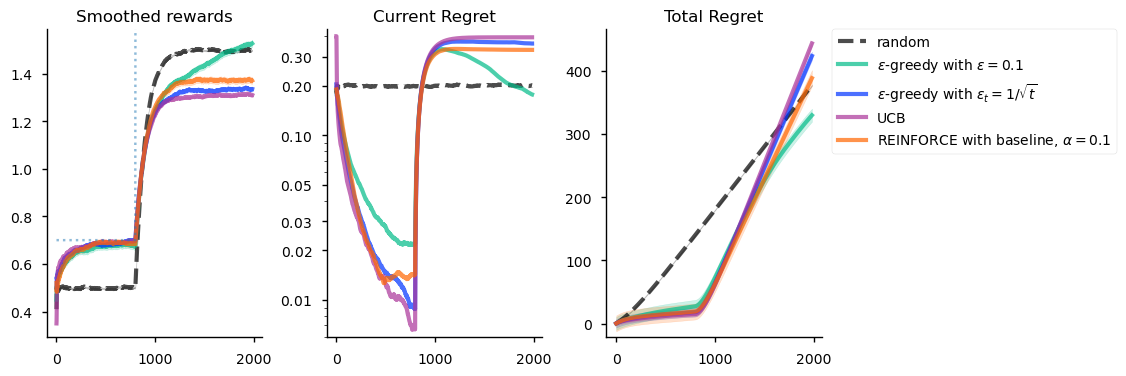

In [15]:
experiment3.show()

C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: divide by zero encountered in log
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))
C:\Users\alina\AppData\Local\Temp\ipykernel_9904\3356031881.py:30: RuntimeWarning: invalid value encountered in sqrt
  U_t = self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N_t +1e-10))


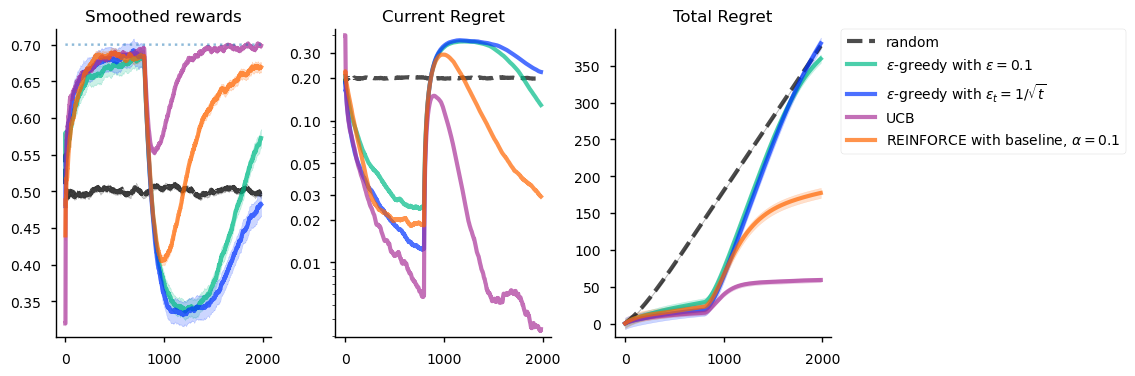

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms. \

**UCB**: This is now the worst performing algorithm with the highest total regret as UCB depends on startionary distribution of rewards over time. Now that this condition is violated, UBC is using it's past rewards to estimate the expected reward for each action, however it is now incorrect as failure is now rewarder higher than success and past rewards are not a correct indicator of future rewards. \
**Epsilon-greedy, epsilon 1/$\sqrt{t}$**: This was the best performing algorith with stationary rewards however now is second worst. This algorithm explores less with every step whereas it needs to explore as the rewards change at half point and hence it does not accurately update action value function due to the lack of exploration at later time steps. \

**Reinforce with baseline, alpha 0.1**: This is performing better then the above altogithms as reinforce uses average rewards as a baseline, which adopts over time. However we are still using assigned action probabilities based on the previous rewards, which with non stationary rewards might not be relevant. Because we are not using discount to emphasise more recent reward this is still a suboptimal solution.

**Epsilon-greedy, epsilon 0.1**: This does the best as it still strickes a blaance with exploration and exploitation even over time as epsilon is stationary and there is always a proportion of exporation present in the learning.\


**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> *Answer here*

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> *Answer here*

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> *Answer here*
